# Text detection with EAST

- Original paper: https://arxiv.org/pdf/1704.03155v2.pdf

# Importing the libraries

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from imutils.object_detection import non_max_suppression

# Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Cursos\ -\ recursos/OCR\ with\ Python/Models/frozen_east_text_detection.pb ./

In [ ]:
!cp -R /content/drive/MyDrive/Cursos\ -\ recursos/OCR\ with\ Python/Images images/

# Pre-processing the image

In [ ]:
detector = '/content/frozen_east_text_detection.pb'
width, height = 320, 320
image = 'images/cup.jpg'
min_confidence = 0.9

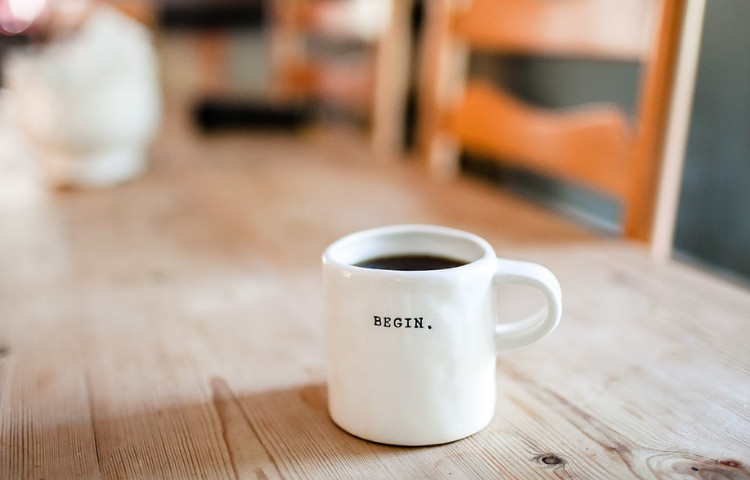

In [ ]:
img = cv2.imread(image)
cv2_imshow(img)

In [ ]:
original = img.copy()

In [ ]:
img.shape

(480, 750, 3)

In [ ]:
H = img.shape[0]
W = img.shape[1]
print(H, W)

480 750


In [ ]:
proportion_W = W / float(width)
proportion_H = H / float(height)
print(proportion_W, proportion_H)

2.34375 1.5


In [ ]:
img = cv2.resize(img, (width, height))
H = img.shape[0]
W = img.shape[1]
print(H, W)

320 320


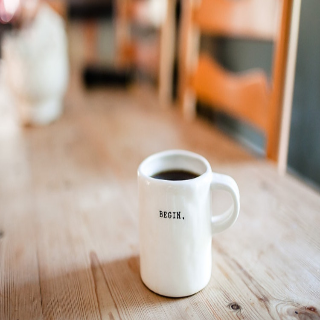

In [ ]:
cv2_imshow(img)

# Loading the neural network

In [ ]:
layers_names = ['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3']

In [ ]:
neural_network = cv2.dnn.readNet(detector)

In [ ]:
img.shape

(320, 320, 3)

In [ ]:
blob = cv2.dnn.blobFromImage(img, 1.0, (W, H), swapRB = True, crop = False)

In [ ]:
blob.shape # batch size

(1, 3, 320, 320)

In [ ]:
neural_network.setInput(blob)
scores, geometry = neural_network.forward(layers_names)

In [ ]:
scores

array([[[[1.47752374e-07, 5.33552679e-07, 6.18313038e-07, ...,
          2.38874441e-06, 2.14221203e-07, 1.97413760e-06],
         [2.21553137e-07, 8.22969994e-08, 1.52692380e-07, ...,
          3.80215579e-06, 2.49685854e-07, 2.09746190e-06],
         [2.41076435e-07, 2.56505132e-07, 6.74969783e-07, ...,
          4.48429728e-06, 6.08908124e-08, 2.51588767e-06],
         ...,
         [5.19031346e-07, 1.34708145e-07, 3.80787064e-08, ...,
          1.79544452e-06, 7.75353328e-07, 5.47008494e-06],
         [2.85663532e-07, 8.55804032e-08, 1.12898597e-07, ...,
          1.13547708e-06, 9.01572434e-07, 5.07820823e-06],
         [7.21993842e-08, 8.43333137e-09, 5.46042234e-09, ...,
          1.91421819e-07, 3.16591752e-07, 1.02402886e-07]]]],
      dtype=float32)

In [ ]:
geometry

array([[[[ 1.54848892e+02,  1.01938652e+02,  1.08211067e+02, ...,
           1.33965744e+02,  1.27577377e+02,  1.46967911e+02],
         [ 1.19407845e+02,  6.46942062e+01,  7.18581467e+01, ...,
           9.02676239e+01,  8.52865753e+01,  1.03320236e+02],
         [ 1.22548698e+02,  6.90612106e+01,  7.86800232e+01, ...,
           1.06370026e+02,  1.01670258e+02,  1.14973625e+02],
         ...,
         [ 1.16457443e+02,  4.99968452e+01,  3.75178909e+01, ...,
           8.21259766e+01,  8.12639771e+01,  1.21695587e+02],
         [ 1.27623566e+02,  5.88201637e+01,  4.84035950e+01, ...,
           8.31772385e+01,  8.09339981e+01,  1.11183853e+02],
         [ 1.26661636e+02,  7.53631363e+01,  6.93250504e+01, ...,
           1.27025375e+02,  1.18697914e+02,  1.47223694e+02]],

        [[ 1.09559792e+02,  9.52129364e+01,  9.08699570e+01, ...,
           1.00495560e+02,  9.43882065e+01,  1.12618568e+02],
         [ 8.27181702e+01,  5.77867126e+01,  5.62353210e+01, ...,
           6.53349457e

In [ ]:
geometry[0,0]

array([[154.84889 , 101.93865 , 108.21107 , ..., 133.96574 , 127.57738 ,
        146.96791 ],
       [119.407845,  64.69421 ,  71.85815 , ...,  90.267624,  85.286575,
        103.32024 ],
       [122.5487  ,  69.06121 ,  78.68002 , ..., 106.370026, 101.67026 ,
        114.973625],
       ...,
       [116.45744 ,  49.996845,  37.51789 , ...,  82.12598 ,  81.26398 ,
        121.69559 ],
       [127.623566,  58.820164,  48.403595, ...,  83.17724 ,  80.934   ,
        111.18385 ],
       [126.66164 ,  75.36314 ,  69.32505 , ..., 127.025375, 118.697914,
        147.2237  ]], dtype=float32)

In [ ]:
scores.shape

(1, 1, 80, 80)

In [ ]:
scores.shape[2:4]

(80, 80)

In [ ]:
rows, columns = scores.shape[2:4]
print(rows, columns)

80 80


In [ ]:
boxes = []
confidences = []

# Decoding the values

- Explanation about geometry: https://stackoverflow.com/questions/55583306/decoding-geometry-output-of-east-text-detection

In [ ]:
def geometric_data(geometry, y):
  xData0 = geometry[0, 0, y]
  xData1 = geometry[0, 1, y]
  xData2 = geometry[0, 2, y]
  xData3 = geometry[0, 3, y]
  angles_data = geometry[0, 4, y]
  return angles_data, xData0, xData1, xData2, xData3

In [ ]:
def geometric_calculation(angles_data, xData0, xData1, xData2, xData3):
  (offsetX, offsetY) = (x * 4.0, y * 4.0)
  angle = angles_data[x]
  cos = np.cos(angle)
  sin = np.sin(angle)
  h = xData0[x] + xData2[x]
  w = xData1[x] + xData3[x]

  endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
  endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))

  beginX = int(endX - w)
  beginY = int(endY - h)

  return beginX, beginY, endX, endY

In [ ]:
rows, columns

(80, 80)

In [ ]:
scores

array([[[[1.47752374e-07, 5.33552679e-07, 6.18313038e-07, ...,
          2.38874441e-06, 2.14221203e-07, 1.97413760e-06],
         [2.21553137e-07, 8.22969994e-08, 1.52692380e-07, ...,
          3.80215579e-06, 2.49685854e-07, 2.09746190e-06],
         [2.41076435e-07, 2.56505132e-07, 6.74969783e-07, ...,
          4.48429728e-06, 6.08908124e-08, 2.51588767e-06],
         ...,
         [5.19031346e-07, 1.34708145e-07, 3.80787064e-08, ...,
          1.79544452e-06, 7.75353328e-07, 5.47008494e-06],
         [2.85663532e-07, 8.55804032e-08, 1.12898597e-07, ...,
          1.13547708e-06, 9.01572434e-07, 5.07820823e-06],
         [7.21993842e-08, 8.43333137e-09, 5.46042234e-09, ...,
          1.91421819e-07, 3.16591752e-07, 1.02402886e-07]]]],
      dtype=float32)

In [ ]:
for y in range(0, rows):
  #print(y)
  data_scores = scores[0, 0, y]
  angles_data, xData0, xData1, xData2, xData3 = geometric_data(geometry, y)
  #print(data_scores)
  #print('-------')
  #print(angles_data, xData0, xData1, xData2, xData3)
  for x in range(0, columns):
    if data_scores[x] < min_confidence:
      continue
    
    beginX, beginY, endX, endY = geometric_calculation(angles_data, xData0, xData1, xData2, xData3)
    confidences.append(data_scores[x])
    boxes.append((beginX, beginY, endX, endY))

In [ ]:
confidences

[0.9995617,
 0.99982554,
 0.9997718,
 0.9994678,
 0.9662514,
 0.96421045,
 0.9993309,
 0.99968016,
 0.99951243]

In [ ]:
boxes

[(156, 208, 190, 220),
 (157, 208, 187, 220),
 (157, 208, 186, 220),
 (158, 207, 186, 220),
 (156, 207, 187, 221),
 (157, 207, 188, 220),
 (158, 208, 187, 221),
 (158, 208, 187, 221),
 (157, 208, 188, 221)]

In [ ]:
detections = non_max_suppression(np.array(boxes), probs = confidences)

In [ ]:
detections

array([[157, 208, 187, 220]])

In [ ]:
proportion_H, proportion_W

(1.5, 2.34375)

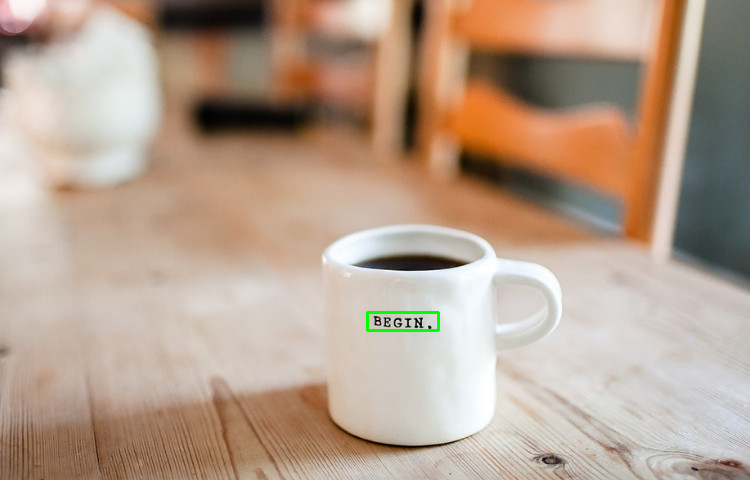

In [ ]:
img_copy = original.copy()
for (beginX, beginY, endX, endY) in detections:
  #print(beginX, beginY, endX, endY)
  beginX = int(beginX * proportion_W)
  beginY = int(beginY * proportion_H)
  endX = int(endX * proportion_W)
  endY = int(endY * proportion_H)

  # region of interest
  roi = img_copy[beginY:endY, beginX:endX]

  cv2.rectangle(original, (beginX, beginY), (endX, endY), (0,255,0), 2)
cv2_imshow(original)

In [ ]:
cv2_imshow(roi)

In [ ]:
roi = cv2.resize(roi, None, fx = 1.5, fy = 1.5, interpolation=cv2.INTER_CUBIC)
cv2_imshow(roi)

# Text recognition

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract 
import pytesseract

In [ ]:
!mkdir tessdata
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
!wget -O ./tessdata/eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true

In [ ]:
!tesseract --help-psm

Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.


In [ ]:
config_tesseract = "--tessdata-dir tessdata --psm 7"

BEGIN,



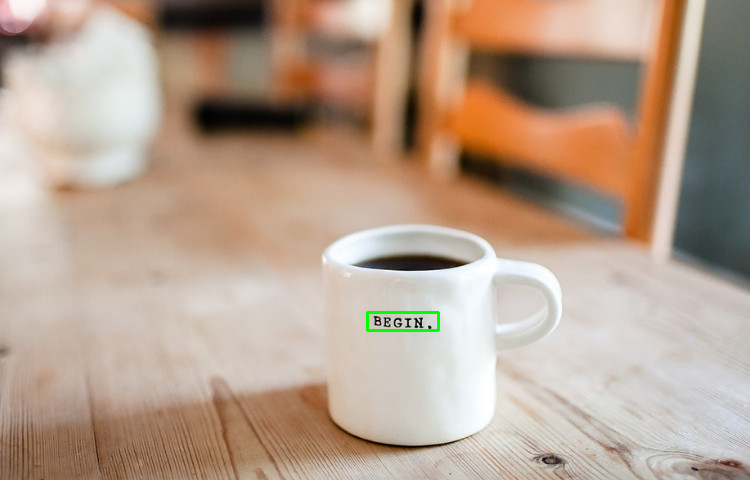

In [ ]:
img_copy = original.copy()
for (beginX, beginY, endX, endY) in detections:
  beginX = int(beginX * proportion_W)
  beginY = int(beginY * proportion_H)
  endX = int(endX * proportion_W)
  endY = int(endY * proportion_H)

  roi = img_copy[beginY:endY, beginX:endX]
  text = pytesseract.image_to_string(roi, lang = 'eng', config=config_tesseract)
  print(text)

  cv2.rectangle(original, (beginX, beginY), (endX, endY), (0,255,0), 2)
cv2_imshow(original)

## Expanding the ROI

BEGIN.



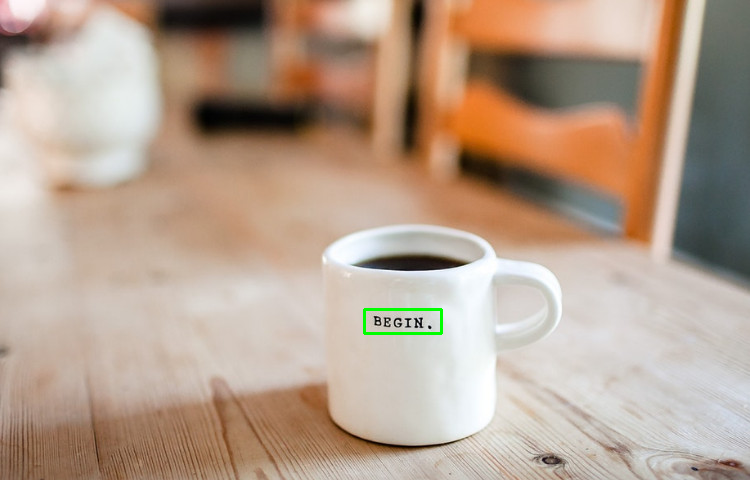

In [ ]:
margin = 3
img_copy = original.copy()
for (beginX, beginY, endX, endY) in detections:
  beginX = int(beginX * proportion_W)
  beginY = int(beginY * proportion_H)
  endX = int(endX * proportion_W)
  endY = int(endY * proportion_H)

  roi = img_copy[beginY - margin:endY + margin, beginX - margin:endX + margin]
  cv2_imshow(roi)
  text = pytesseract.image_to_string(roi, lang = 'eng', config=config_tesseract)
  print(text)

  cv2.rectangle(img_copy, (beginX - margin, beginY - margin), (endX + margin, endY + margin), (0,255,0), 2)
cv2_imshow(img_copy)